In [1]:
# My custom library of photoelastic tools
import sys
sys.path.append('/home/jack/workspaces/jupyter-workspace/pepe/')

from pepe.preprocess import circularMask, crossMask, mergeMasks
from pepe.simulate import genSyntheticResponse
from pepe.analysis import g2ForceCalibration, adjacencyMatrix, detectWallContacts, gSquared, initialForceSolve

import numpy as np

#from scipy.optimize import minimize, leastsq
from lmfit import minimize, Parameters, fit_report

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 140

from IPython.display import clear_output

# For timing
import time

In [16]:
# Generate a bunch of fake data
numParticles = 20

# Material properties
fSigma = 100.
pxPerMeter = 10000.
brightfield = False
imageShape = (513, 641, 3)

# Same center for every particle
center = np.array([imageShape[0]/2, imageShape[1]/2], dtype=np.int64)
radius = 201

# The number of forces that will be acting on each particle
numForces = np.int16(np.floor(np.random.uniform(2, 5, size=numParticles)))

# Append to these as we go, since triangular arrays are annoying in numpy
trueForceArr = []
trueBetaArr = []
trueAlphaArr = []

guessForceArr = []
guessBetaArr = []
guessAlphaArr = []

for i in range(numParticles):
    # Uniformly generate forces in interval [0,1]
    trueForceArr.append(np.random.uniform(0, .6, size=numForces[i]))
    
    # Betas should be approximately equally distributed around the particle
    # (it would be unphysical to have four forces all acting on one side)
    trueBetaArr.append(np.random.normal(0, .1, size=numForces[i]) + np.linspace(-np.pi+1, np.pi-1, numForces[i]))
    
    # Alphas can just be a normal distribution around 0
    # For circles, we almost always have radial forces, so the width
    # of this random distribution is pretty small
    trueAlphaArr.append(np.abs(np.random.normal(0, .01, size=numForces[i])))
    
    # Now, to generate our guesses, we just add some noise to each true answer
    guessForceArr.append(np.abs(trueForceArr[-1] + np.random.normal(0, .3, size=numForces[i])))
    
    # Beta guesses should be pretty accurate, since we get these from contacts directions
    guessBetaArr.append(trueBetaArr[-1] + np.random.normal(0, .005, size=numForces[i]))
    
    # Alpha guesses always start at 0
    guessAlphaArr.append(np.zeros(numForces[i]))

In [17]:
# Generate the true images for all of the particles
trueImageArr = [genSyntheticResponse(trueForceArr[i], trueAlphaArr[i], trueBetaArr[i],
                                     fSigma, radius, pxPerMeter, brightfield, imageSize=imageShape[:2], center=center) for i in range(numParticles)]

guessImageArr = [genSyntheticResponse(guessForceArr[i], guessAlphaArr[i], guessBetaArr[i],
                                      fSigma, radius, pxPerMeter, brightfield, imageSize=imageShape[:2], center=center) for i in range(numParticles)]

# Add a little bit of noise (~20:1 ratio)
trueImageArr = [np.abs(trueImageArr[i] + np.random.uniform(-.15, .15, size=imageShape[:2])) for i in range(numParticles)]

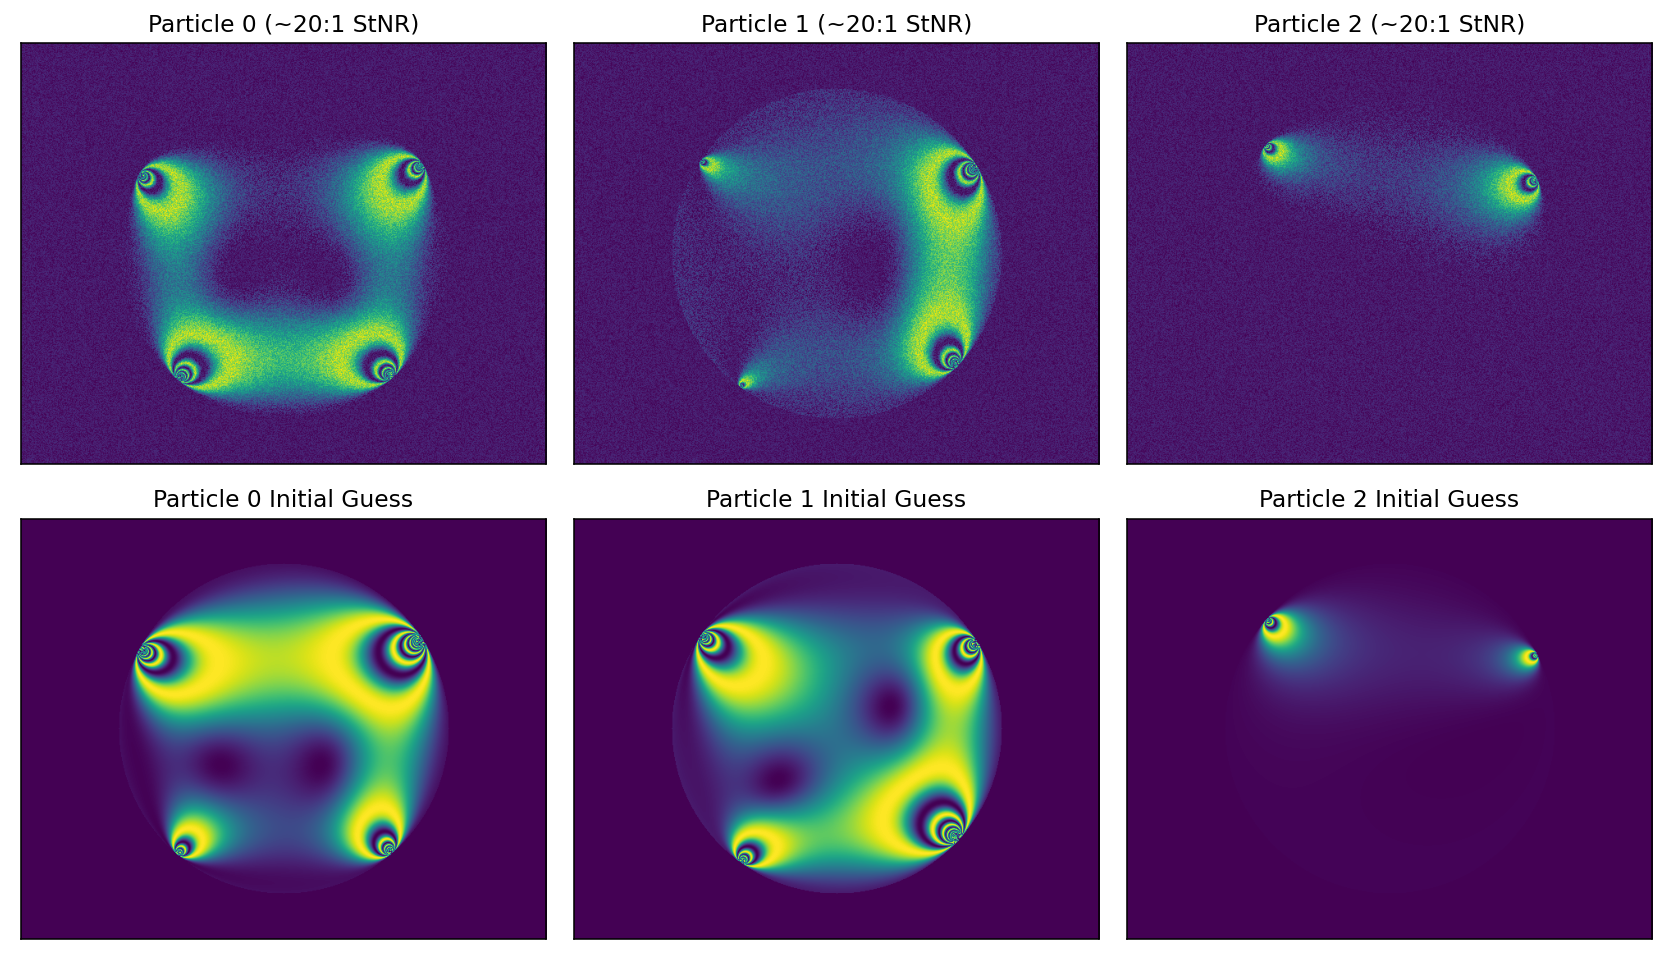

In [18]:
# Show a few particles, and their guesses
fig, ax = plt.subplots(2, 3, figsize=(12, 7))

for i in range(3):
    ax[0,i].imshow(trueImageArr[i])
    ax[0,i].set_title(f'Particle {i} (~20:1 StNR)')
    ax[1,i].imshow(guessImageArr[i])
    ax[1,i].set_title(f'Particle {i} Initial Guess')

    ax[0,i].set_xticks([])
    ax[1,i].set_xticks([])
    ax[0,i].set_yticks([])
    ax[1,i].set_yticks([])
    
fig.tight_layout()
plt.show()

In [19]:
def optimize(forceGuess, betaGuess, alphaGuess, realImage, method, parametersToFit=['f', 'a'], max_evals=1000):
    # Which parameters to actually fit

    residuals = []

    # Setup our function based on what parameters we are fitting
    # We want to avoid any if statements within the function itself, since
    # that will be evaluated many many times
    def objectiveFunction(params, trueImage, z, radius, center):
        forceArr = np.array([params[f"f{j}"] for j in range(z)])
        betaArr = np.array([params[f"b{j}"] for j in range(z)])
        alphaArr = np.array([params[f"a{j}"] for j in range(z)])

        synImage = genSyntheticResponse(forceArr, alphaArr, betaArr, fSigma, radius, pxPerMeter, brightfield, imageSize=imageShape[:2], center=center)

        #plt.imshow(synImage)
        #plt.show()
        #plt.imshow(trueImage)
        #plt.show()
        #clear_output(wait=True)
        #residuals.append(np.sum(np.abs(synImage - trueImage)))
        #plt.plot(residuals)
        #plt.yscale('log')
        #plt.show()
        #print(np.sum(np.abs(synImage)))

        return np.sum(np.abs(synImage - trueImage))


    # Setup our real image
    particleMask = circularMask(realImage.shape, center, radius)[:,:,0]
    maskedImage = realImage * particleMask

    angleBounds = (-np.pi, np.pi)
    strictAngleBounds = (-np.pi/8., np.pi/8.) # Alpha really shouldn't change that much
    forceBounds = (0, 1)

    forceTol = 1.
    betaTol = .1
    alphaTol = np.pi
    
    # Out fitting parameters
    # if vary kwarg is false, that value won't be fit
    params = Parameters()
    z = len(forceGuess)
    for j in range(z):
        #params.add(f'f{j}', value=forceGuess[j], vary='f' in parametersToFit, min=forceBounds[0], max=forceBounds[1])
        #params.add(f'b{j}', value=betaGuess[j], vary='b' in parametersToFit, min=angleBounds[0], max=angleBounds[1])
        #params.add(f'a{j}', value=alphaGuess[j], vary='a' in parametersToFit, min=strictAngleBounds[0], max=strictAngleBounds[1])
        
        params.add(f'f{j}', value=forceGuess[j], vary='f' in parametersToFit, min=max(forceGuess[j]-forceTol, 0), max=forceGuess[j]+forceTol)
        params.add(f'b{j}', value=betaGuess[j], vary='b' in parametersToFit, min=max(betaGuess[j]-betaTol, -np.pi), max=min(betaGuess[j]+betaTol, np.pi))
        params.add(f'a{j}', value=alphaGuess[j], vary='a' in parametersToFit, min=max(alphaGuess[j]-alphaTol, 0), max=alphaGuess[j]+alphaTol)

    #params.pretty_print()
        
    # Now do the optimization
    result = minimize(objectiveFunction, params,
                     args=(maskedImage, z, radius, center),
                     method=method, nan_policy='omit', max_nfev=max_evals)

    return result

    #result.params.pretty_print()cobyla
    optimizedForceArr = np.array([result.params[f"f{j}"] for j in range(z)])
    optimizedBetaArr = np.array([result.params[f"b{j}"] for j in range(z)])
    optimizedAlphaArr = np.array([result.params[f"a{j}"] for j in range(z)])

    return optimizedForceArr, optimizedBetaArr, optimizedAlphaArr, residuals

In [8]:
# Now to actually test each optimization method
methodArr = ['powell', 'bfgsb', 'cobyla',  'nelder', ]

forceErrorArr = np.zeros((len(methodArr), numParticles))
betaErrorArr = np.zeros((len(methodArr), numParticles))
alphaErrorArr = np.zeros((len(methodArr), numParticles))

for i in range(len(methodArr)):
    startTime = time.perf_counter()
    print(methodArr[i])
    for j in range(numParticles):
        z = numForces[j]
        # Lower is (almost) always better for force x0, so divide by 2
        res = optimize(guessForceArr[j]/2, guessBetaArr[j], guessAlphaArr[j],
                                                     trueImageArr[j], methodArr[i], parametersToFit=['f', 'b'], max_evals=300)
        
        optForce = np.array([res.params[f"f{j}"] for j in range(z)])
        optBeta = np.array([res.params[f"b{j}"] for j in range(z)])
        optAlpha = np.array([res.params[f"a{j}"] for j in range(z)])

        # plt.plot(res)
        # plt.yscale('log')
        # plt.show()
        forceErrorArr[i,j] = np.mean(trueForceArr[j] - optForce)
        betaErrorArr[i,j] = np.mean(trueBetaArr[j] - optBeta)
        alphaErrorArr[i,j] = np.mean(trueAlphaArr[j] - optAlpha)

        
        # optForces, optBeta, optAlpha, res2 = optimize(optForce, optBeta, optAlpha,
        #                                             trueImageArr[j], methodArr[i], parametersToFit=['f', 'a'], max_evals=200)
        # plt.plot(res2)
        # plt.yscale('log')
        # plt.show()
    print(f'{methodArr[i]} finished in: {time.perf_counter() - startTime} seconds')

powell
powell finished in: 368.1742341120007 seconds
bfgsb
bfgsb finished in: 368.90082101699954 seconds
cobyla


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.
capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.
capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.
capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


cobyla finished in: 219.48103307099882 seconds
nelder
nelder finished in: 353.8658487160028 seconds


In [46]:
np.mean(betaErrorArr, axis=-1)

array([ 0.00116706,  0.00020613, -0.02663222,  0.00020613])

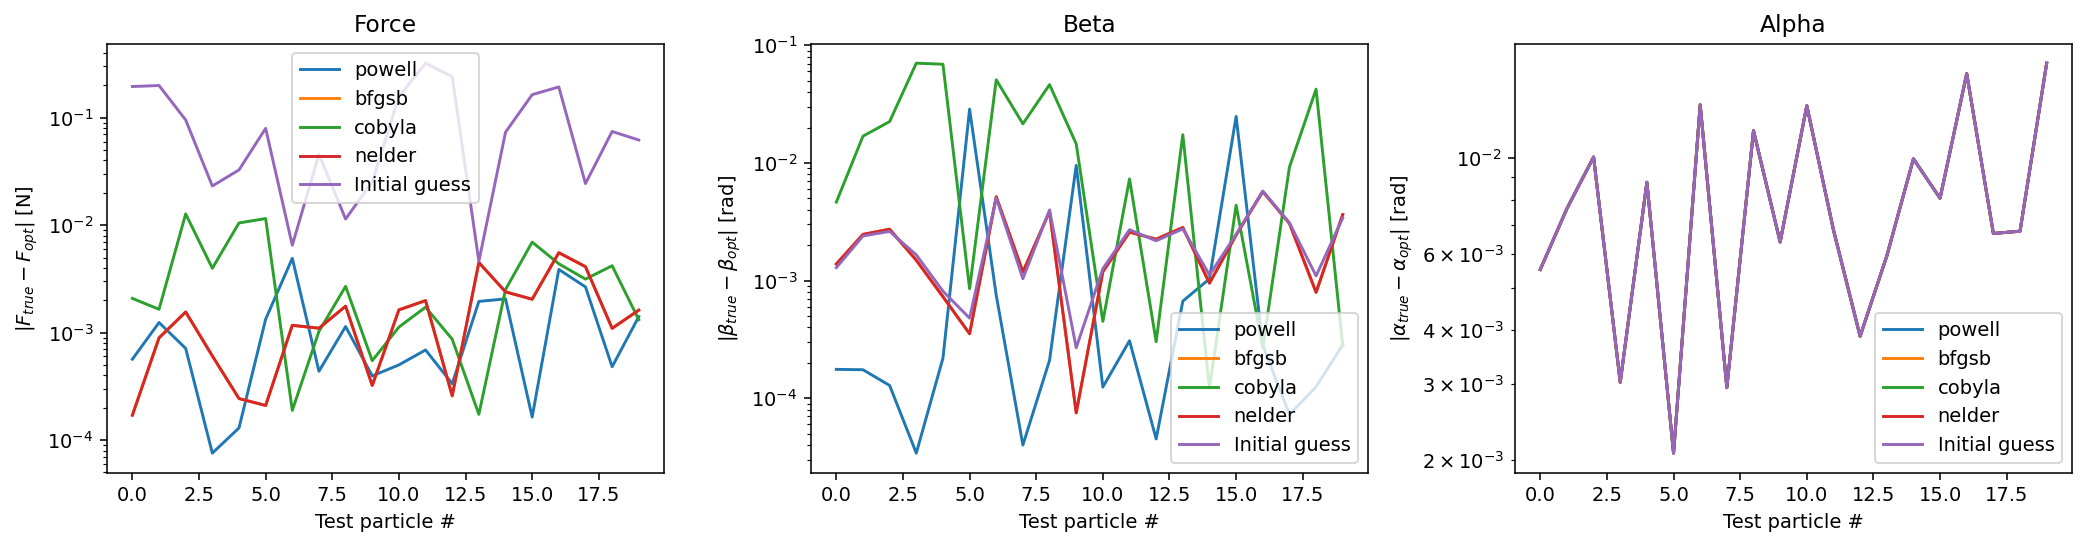

In [31]:
fig, ax = plt.subplots(1, 3, figsize=(15,4))

forceGuessErrorArr = np.zeros(numParticles)
betaGuessErrorArr = np.zeros(numParticles)
alphaGuessErrorArr = np.zeros(numParticles)

for i in range(numParticles):
    forceGuessErrorArr[i] = np.mean(guessForceArr[i] - trueForceArr[i])
    betaGuessErrorArr[i] = np.mean(guessBetaArr[i] - trueBetaArr[i])
    alphaGuessErrorArr[i] = np.mean(guessAlphaArr[i] - trueAlphaArr[i])

for i in range(len(methodArr)):
    ax[0].plot(np.abs(forceErrorArr[i]), label=methodArr[i])
    ax[1].plot(np.abs(betaErrorArr[i]), label=methodArr[i])
    ax[2].plot(np.abs(alphaErrorArr[i]), label=methodArr[i])
    
ax[0].plot(np.abs(forceGuessErrorArr), label='Initial guess')
ax[1].plot(np.abs(betaGuessErrorArr), label='Initial guess')
ax[2].plot(np.abs(alphaGuessErrorArr), label='Initial guess')
    
ax[0].set_ylabel(r'$|F_{true} - F_{opt}|$ [N]')
ax[0].set_title('Force')
ax[1].set_ylabel(r'$|\beta_{true} - \beta_{opt}|$ [rad]')
ax[1].set_title('Beta')
ax[2].set_ylabel(r'$|\alpha_{true} - \alpha_{opt}|$ [rad]')
ax[2].set_title('Alpha')

for i in range(3):
    ax[i].set_xlabel('Test particle #')
    ax[i].legend()
    ax[i].set_yscale('log')
    
fig.tight_layout()
plt.savefig('../images/optimization_methods/error_comparison.png')
plt.show()

In [21]:
# Nelder seems to be the most stable (which is the same as bfgsb)
# so we'll use that one
methodArr = ['powell', 'bfgsb', 'cobyla',  'nelder']

noiseLevelArr = np.linspace(0, .75, 5)

forceErrorArr = np.zeros((len(methodArr), len(noiseLevelArr), numParticles))
betaErrorArr = np.zeros((len(methodArr), len(noiseLevelArr), numParticles))
alphaErrorArr = np.zeros((len(methodArr), len(noiseLevelArr), numParticles))

for l in range(len(methodArr)):
    print(l)
    for i in range(len(noiseLevelArr)):
        print(f'   {i}')
        # Generate the true images for all of the particles
        trueImageArr = [genSyntheticResponse(trueForceArr[k], trueAlphaArr[k], trueBetaArr[k],
                                             fSigma, radius, pxPerMeter, brightfield, imageSize=imageShape[:2], center=center) for k in range(numParticles)]


        # Add a variable amount of noise
        trueImageArr = [np.abs(trueImageArr[k] + np.random.uniform(-noiseLevelArr[i], noiseLevelArr[i], size=imageShape[:2])) for k in range(numParticles)]

        for j in range(numParticles):
            z = numForces[j]
            # Lower is (almost) always better for force x0, so divide by 2
            res = optimize(guessForceArr[j]/2, guessBetaArr[j], guessAlphaArr[j],
                                                         trueImageArr[j], methodArr[l], parametersToFit=['f', 'b'], max_evals=200)

            optForce = np.array([res.params[f"f{j}"] for j in range(z)])
            optBeta = np.array([res.params[f"b{j}"] for j in range(z)])
            optAlpha = np.array([res.params[f"a{j}"] for j in range(z)])

            # plt.plot(res)
            # plt.yscale('log')
            # plt.show()
            forceErrorArr[l,i,j] = np.mean(trueForceArr[j] - optForce)
            betaErrorArr[l,i,j] = np.mean(trueBetaArr[j] - optBeta)
            alphaErrorArr[l,i,j] = np.mean(trueAlphaArr[j] - optAlpha)

0
   0
   1
   2
   3
   4
1
   0
   1
   2


AbortFitException: fit aborted: too many function evaluations 200

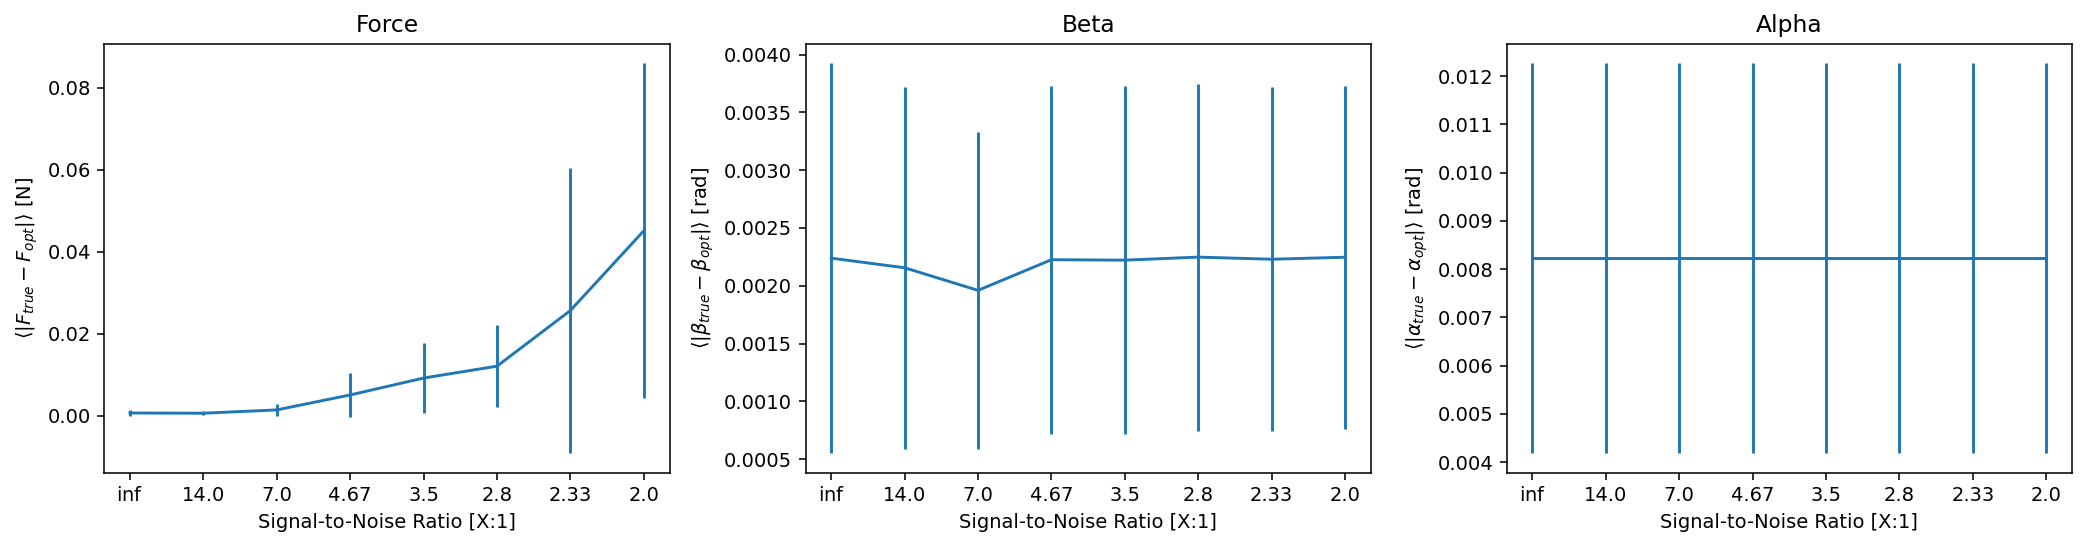

In [54]:
fig, ax = plt.subplots(1, 3, figsize=(15,4))

forceErrorByNoise = np.mean(np.abs(forceErrorArr), axis=-1)
betaErrorByNoise = np.mean(np.abs(betaErrorArr), axis=-1)
alphaErrorByNoise = np.mean(np.abs(alphaErrorArr), axis=-1)

forceErrorBarByNoise = np.std(np.abs(forceErrorArr), axis=-1)
betaErrorBarByNoise = np.std(np.abs(betaErrorArr), axis=-1)
alphaErrorBarByNoise = np.std(np.abs(alphaErrorArr), axis=-1)

ax[0].errorbar(range(len(noiseLevelArr)), forceErrorByNoise, yerr=forceErrorBarByNoise)
ax[1].errorbar(range(len(noiseLevelArr)), betaErrorByNoise, yerr=betaErrorBarByNoise)
ax[2].errorbar(range(len(noiseLevelArr)), alphaErrorByNoise, yerr=alphaErrorBarByNoise)

ax[0].set_ylabel(r'$\langle|F_{true} - F_{opt}|\rangle$ [N]')
ax[0].set_title('Force')
ax[1].set_ylabel(r'$\langle|\beta_{true} - \beta_{opt}|\rangle$ [rad]')
ax[1].set_title('Beta')
ax[2].set_ylabel(r'$\langle|\alpha_{true} - \alpha_{opt}|\rangle$ [rad]')
ax[2].set_title('Alpha')

for i in range(3):
    ax[i].set_xlabel('Signal-to-Noise Ratio [X:1]')
    #ax[i].legend()
    ax[i].set_xticks(range(len(noiseLevelArr)), [r'$\inf$'] + [f'{1/n:.3}' for n in noiseLevelArr[1:]])
#    ax[i].set_yscale('log')
    
fig.tight_layout()
plt.savefig('../images/optimization_methods/noise_level_comparison.png')
plt.show()

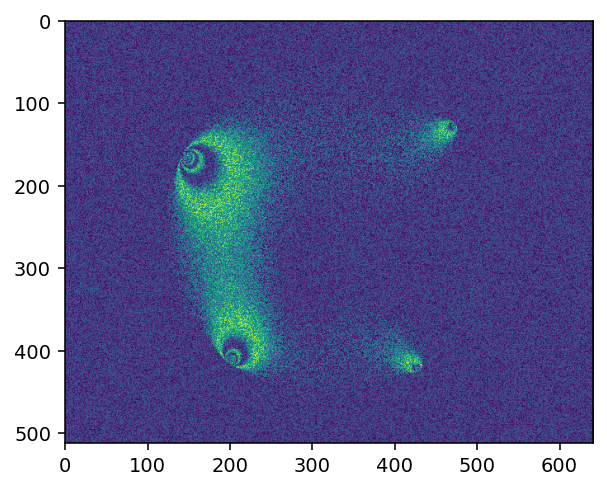

In [57]:
plt.imshow(trueImageArr[0])
plt.savefig('../images/optimization_methods/noisy_sample.png')
plt.show()

In [ ]:
# Nelder seems to be the most stable (which is the same as bfgsb)
# so we'll use that one
method = 'nelder'
maxEvalsArr = np.linspace(100, 1000, 5)

forceErrorArr = np.zeros((len(maxEvalsArr), numParticles))
betaErrorArr = np.zeros((len(maxEvalsArr), numParticles))
alphaErrorArr = np.zeros((len(maxEvalsArr), numParticles))

# Generate the true images for all of the particles
trueImageArr = [genSyntheticResponse(trueForceArr[k], trueAlphaArr[k], trueBetaArr[k],
                                     fSigma, radius, pxPerMeter, brightfield, imageSize=imageShape[:2], center=center) for k in range(numParticles)]


# Add a variable amount of noise
trueImageArr = [np.abs(trueImageArr[k] + np.random.uniform(-.15, .15, size=imageShape[:2])) for k in range(numParticles)]


for i in range(len(maxEvalsArr)):
    print(i)

    for j in range(numParticles):
        z = numForces[j]
        # Lower is (almost) always better for force x0, so divide by 2
        res = optimize(guessForceArr[j]/2, guessBetaArr[j], guessAlphaArr[j],
                                                     trueImageArr[j], method, parametersToFit=['f', 'b'], max_evals=maxEvalsArr[i])
        
        optForce = np.array([res.params[f"f{j}"] for j in range(z)])
        optBeta = np.array([res.params[f"b{j}"] for j in range(z)])
        optAlpha = np.array([res.params[f"a{j}"] for j in range(z)])

        # plt.plot(res)
        # plt.yscale('log')
        # plt.show()
        forceErrorArr[i,j] = np.mean(trueForceArr[j] - optForce)
        betaErrorArr[i,j] = np.mean(trueBetaArr[j] - optBeta)
        alphaErrorArr[i,j] = np.mean(trueAlphaArr[j] - optAlpha)

In [39]:
noiseLevelArr

array([0.        , 0.07142857, 0.14285714, 0.21428571, 0.28571429,
       0.35714286, 0.42857143, 0.5       ])

In [15]:
a = [['a', 'f'], ['b', 'f']]
b = ['a', 'f']
type(b[0]) == list

False